<a href="https://colab.research.google.com/github/ZahraDehghani99/FacemaskWearingAlertSystem/blob/main/FaceMaskClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Mask Classifier

In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D
from tensorflow.keras.layers import GlobalAveragePooling2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Concatenate, Add, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 200
BS = 16
TRAIN_DATA_DIR = "/content/drive/MyDrive/DIP_final_proj/face-mask-classifier-dataset/"

In [ ]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images(TRAIN_DATA_DIR + "dataset_CDD"))
print(f"[INFO] loading finished. {len(imagePaths)} images loaded.")


[INFO] loading images...
[INFO] loading finished. 4092 images loaded.


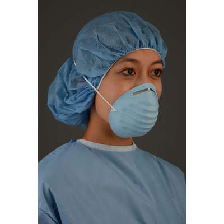

In [ ]:
example = load_img(imagePaths[0], target_size=(224, 224))
example

In [ ]:
example = img_to_array(example)
example.shape

(224, 224, 3)

below takes 16 mins for 4092 images.

In [ ]:
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	# image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
data[0].shape

(224, 224, 3)

In [ ]:
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [ ]:
data[0].shape

(224, 224, 3)

In [ ]:
# partition the data into training and testing splits using 70% of
# the data for training and the remaining 30% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.30, stratify=labels, random_state=42)

In [ ]:
trainX.shape

(2864, 224, 224, 3)

In [ ]:
testX.shape

(1228, 224, 224, 3)

In [ ]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

trainY = to_categorical(trainY)
testY = to_categorical(testY)

In [ ]:
trainY

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [ ]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", monitor = 'val_accuracy',verbose=1, save_best_only=True)

In [ ]:
input_model = Input((224,224,3),name = 'input_layer')

conv1 = Conv2D(16, (7,7), padding="same", activation='relu',name = 'Conv1')(input_model)
bnorm1 = BatchNormalization(name = 'Bnorm1')(conv1)
avg1 = AveragePooling2D((2, 2), name = 'AvgPool1')(bnorm1) # strides = (2, 2)


dw1 = SeparableConv2D(32, (5,5), padding="same", activation='relu', name= 'Conv2')(avg1)
bnorm2 = BatchNormalization(name = 'Bnorm2')(dw1)
avg2 = AveragePooling2D((2, 2), name = 'AvgPool2')(bnorm2)


skip_connect1 = Conv2D(32, (1,1), strides=(4, 4), activation='relu',name = 'skip-connection1')(conv1)
bnorm_skip1 = BatchNormalization(name = 'Bnorm_skip1')(skip_connect1)
res1 = Add()([bnorm_skip1, avg2])


conv2 = Conv2D(64, (3,3), padding="same", activation='relu', name = 'Conv3')(res1) # res1
bnorm3 = BatchNormalization(name = 'Bnorm3')(conv2)
avg3 = AveragePooling2D((2, 2), name = 'AvgPool3')(bnorm3)


skip_connect2 = Conv2D(64, (1,1), strides=(2, 2), activation='relu',name = 'skip-connection2')(res1)
bnorm_skip2 = BatchNormalization(name = 'Bnorm_skip2')(skip_connect2)
res2 = Add()([bnorm_skip2, avg3])


dw2 = SeparableConv2D(128, (3,3), padding='same', activation='relu', name='Conv4')(res2) # res2
bnorm4 = BatchNormalization(name = 'Bnorm4')(dw2)
avg4 = AveragePooling2D((2, 2), name = 'AvgPool4')(bnorm4)


skip_connect3 = Conv2D(128, (1,1), strides=(2, 2), activation='relu',name = 'skip-connection3')(res2)
bnorm_skip1 = BatchNormalization(name = 'Bnorm_skip3')(skip_connect3)
res3 = Add()([bnorm_skip1, avg4])


conv3 = Conv2D(256, (3,3), padding="same", activation='relu', name = 'Conv5')(res3) #r###
bnorm5 = BatchNormalization(name = 'Bnorm5')(conv3)


conv4 = Conv2D(2, (3,3), padding="same", activation='relu', name = 'Conv6')(conv3) 
bnorm6 = BatchNormalization(name = 'Bnorm6')(conv4)


skip_connect4 = Conv2D(2, (1,1), strides=(1, 1), activation='relu',name = 'skip-connection4')(res3)
bnorm_skip4 = BatchNormalization(name = 'Bnorm_skip4')(skip_connect4)
res4 = Add()([bnorm_skip4, bnorm6])


gavg = GlobalAveragePooling2D()(res4) #res4
output = Dense(units = 2, activation = 'softmax' , name='preds')(gavg)

model = Model(inputs= [input_model], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 224, 224, 16  2368        ['input_layer[0][0]']            
                                )                                                                 
                                                                                                  
 Bnorm1 (BatchNormalization)    (None, 224, 224, 16  64          ['Conv1[0][0]']                  
                                )                                                             

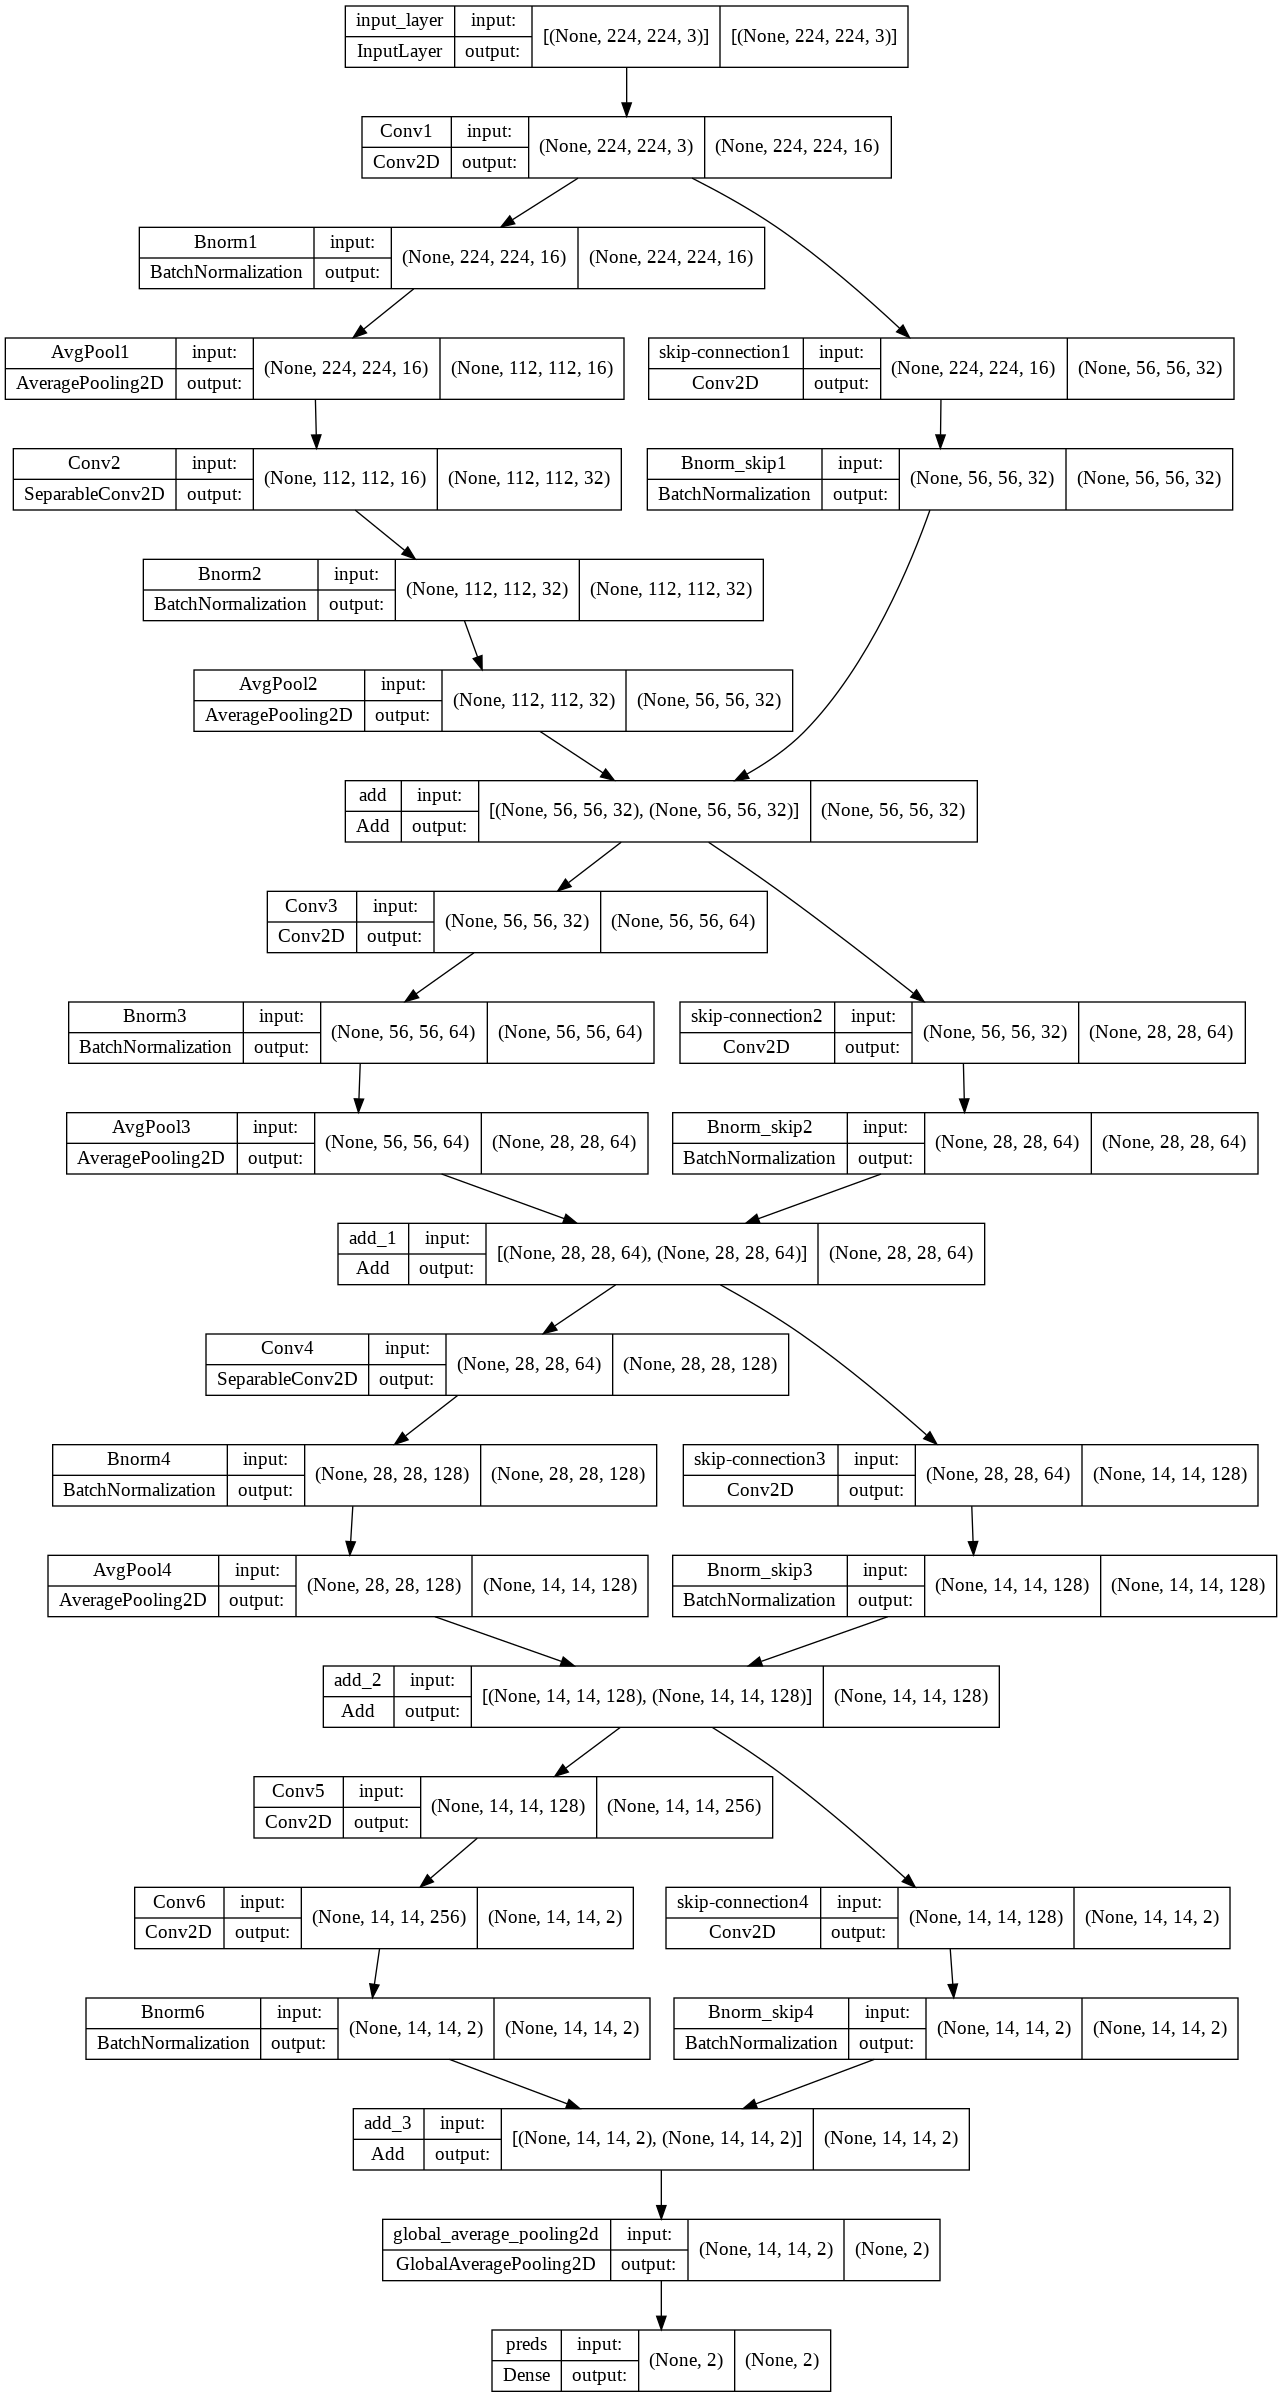

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(aug.flow(trainX, trainY, batch_size=BS),
							steps_per_epoch=len(trainX) // BS,
							validation_data=(testX, testY),
							validation_steps=len(testX) // BS,
							epochs=EPOCHS, 
							callbacks=[checkpointer])

[INFO] training head...
Epoch 1/10
89/89 [==============================] - 52s 430ms/step - loss: 0.4900 - accuracy: 0.7843 - val_loss: 0.7426 - val_accuracy: 0.5285
Epoch 2/10
89/89 [==============================] - 36s 399ms/step - loss: 0.4426 - accuracy: 0.8280 - val_loss: 0.7154 - val_accuracy: 0.5293
Epoch 3/10
89/89 [==============================] - 36s 400ms/step - loss: 0.4221 - accuracy: 0.8407 - val_loss: 0.4944 - val_accuracy: 0.8021
Epoch 4/10
89/89 [==============================] - 35s 398ms/step - loss: 0.4042 - accuracy: 0.8619 - val_loss: 0.5089 - val_accuracy: 0.7850
Epoch 5/10
89/89 [==============================] - 36s 399ms/step - loss: 0.3955 - accuracy: 0.8535 - val_loss: 0.4202 - val_accuracy: 0.8249
Epoch 6/10
89/89 [==============================] - 36s 399ms/step - loss: 0.3796 - accuracy: 0.8690 - val_loss: 0.3815 - val_accuracy: 0.8640
Epoch 7/10
89/89 [==============================] - 35s 397ms/step - loss: 0.3728 - accuracy: 0.8736 - val_loss: 0.378

In [ ]:
model.save_weights("model1_weights_hist.h5")
model.save("model1_hist.h5")

load model

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/gdrive/MyDrive/proj2_1/model2_hist.h5')

In [ ]:
val_loss = history.history['val_loss']
loss = history.history['loss']

plt.plot(val_loss)
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Val error','Train error'], loc='upper right')
plt.savefig('plot_error1.png')
plt.show()


In [ ]:
val_accuracy = history.history['val_accuracy']
accuracy = history.history['accuracy']

plt.plot(val_accuracy)
plt.plot(accuracy)
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(['Val accuracy','Train accuracy'], loc='upper right')
plt.savefig( 'plot_accuracy1.png')
plt.show()

In [ ]:
# امتحان کردن مدل
num = 20
test_list = []
for i in range(num):
  test_list.append(X_test[i])
test_list = np.array(test_list)  

# این دو خط بعدی نتیجه پیش بینی شده روی دادههای تست را نشان می دهدو چون تابع فعالیت آرگ مکس است عنصری که بیشترین احتمال را دارد به عنوان برچسب برای عکس استفاده می شود
predict_test = model.predict(test_list)
predict_test_id = predict_test.argmax(axis=1) 

f = plt.figure(figsize=(20, 16))
for i in range(num):
    plt.subplot(num, 2, i+1)
    plt.imshow(test_list[i])
    plt.title(f'predicted = {classID_signames[predict_test_id[i]]}')
    plt.axis('off')
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.4)

# confusion matrix

In [ ]:
y_pred = model.predict(X_test)
print(y_pred)
pred_id = np.argmax(y_pred, axis=1)
print(pred_id)

In [ ]:
y_test_id = np.argmax(y_test, axis=1)
print(y_test_id)


In [ ]:
y_true = [classID_signames[i] for i in y_test_id]
y_pred = [classID_signames[i] for i in pred_id]
data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (50,50))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

In [ ]:


from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
import seaborn as sns



In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [ ]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save(args["model"], save_format="h5")

In [ ]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])